In [2]:
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
from datetime import date, datetime
from jupyter_dash import JupyterDash

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from pprint import pprint
import seaborn as sns
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import estimator_html_repr
from scipy.stats import loguniform

In [3]:
car_price_df = pd.read_csv("data_pricing_challenge.csv", parse_dates=["registration_date", "sold_at"])
car_price_df

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,BMW,218 Gran Tourer,39743,110,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,14600,2018-08-01
4839,BMW,218 Active Tourer,49832,100,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,17500,2018-08-01
4840,BMW,218 Gran Tourer,19633,110,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,17000,2018-09-01
4841,BMW,218 Active Tourer,27920,110,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700,2018-09-01


In [4]:
# check for null values
print(f"Total Nulls in Dataset: {car_price_df.isnull().sum().sum()}")
# check data types
print(f"Data types:\n{car_price_df.dtypes}")

Total Nulls in Dataset: 0
Data types:
maker_key                    object
model_key                    object
mileage                       int64
engine_power                  int64
registration_date    datetime64[ns]
fuel                         object
paint_color                  object
car_type                     object
feature_1                      bool
feature_2                      bool
feature_3                      bool
feature_4                      bool
feature_5                      bool
feature_6                      bool
feature_7                      bool
feature_8                      bool
price                         int64
sold_at              datetime64[ns]
dtype: object


In [5]:
# check if all BMW
print(car_price_df.maker_key.unique())
features = [f"feature_{i}" for i in range(1,9)]
cat_var = ["model_key", "fuel", "paint_color", "car_type", *features]
num_var = ["mileage", "engine_power", "registration_date", "sold_at"]
target = ["price"]

['BMW']


In [6]:
# check 2018 is sold year only
print(f"Sold year values: {car_price_df.sold_at.dt.year.unique()}")
# check number of sales per month
print(f"Sales per month:\n{car_price_df.sold_at.dt.month.value_counts()}")
# transform column to sold month (model seasonality)
car_price_df.loc[:, "sold_at"] = car_price_df.sold_at.dt.month


Sold year values: [2018]
Sales per month:
5    809
3    739
4    693
6    604
7    537
8    528
2    502
9    223
1    208
Name: sold_at, dtype: int64


In [7]:
# count registration years
print(f"Registration years:\n{car_price_df.registration_date.dt.year.value_counts()}")
# transform column to registrated year (simplify car age)
car_price_df.loc[:, "registration_date"] = car_price_df.registration_date.dt.year

Registration years:
2013    1546
2014    1288
2012     820
2015     311
2011     215
2008     103
2010     103
2009      87
2016      83
2006      67
2007      59
2005      54
2004      28
2001      17
2003      16
2017      11
2000      10
2002       9
1997       5
1999       4
1996       2
1998       2
1995       1
1990       1
1994       1
Name: registration_date, dtype: int64


In [8]:
# describe numerical variables mileage, engine_power and target price
print(car_price_df[[*num_var, *target]].describe())
# zero engine_power entries
print(f"Cars with zero engine_power entries: {(car_price_df.engine_power == 0).sum()}")
# cars with negative mileage entries
print(f"Cars with negative mileage entries: {(car_price_df.mileage < 0).sum()}")

            mileage  engine_power  registration_date      sold_at  \
count  4.843000e+03    4843.00000        4843.000000  4843.000000   
mean   1.409628e+05     128.98823        2012.467479     4.926698   
std    6.019674e+04      38.99336           2.526997     2.157615   
min   -6.400000e+01       0.00000        1990.000000     1.000000   
25%    1.029135e+05     100.00000        2012.000000     3.000000   
50%    1.410800e+05     120.00000        2013.000000     5.000000   
75%    1.751955e+05     135.00000        2014.000000     7.000000   
max    1.000376e+06     423.00000        2017.000000     9.000000   

               price  
count    4843.000000  
mean    15828.081767  
std      9220.285684  
min       100.000000  
25%     10800.000000  
50%     14200.000000  
75%     18600.000000  
max    178500.000000  
Cars with zero engine_power entries: 1
Cars with negative mileage entries: 1


In [9]:
# drop the two cases above
car_price_df.drop(car_price_df[car_price_df.engine_power == 0].index, inplace=True)
car_price_df.drop(car_price_df[car_price_df.mileage < 0].index, inplace=True)

# count engine power
print(f"Engine Power counts:\n{car_price_df.engine_power.value_counts()}")

Engine Power counts:
135    882
120    785
85     631
100    570
105    451
190    319
140    166
160    153
110    142
230    119
155     99
180     62
225     49
130     47
150     43
90      40
280     32
122     30
173     25
210     21
137     19
125     16
170     14
70      11
145      9
75       9
235      7
142      6
87       6
240      5
220      5
127      5
112      5
80       4
119      4
309      4
317      4
77       3
195      3
107      3
95       3
200      3
25       2
192      2
101      2
189      2
141      2
270      2
66       2
183      2
233      2
224      1
423      1
300      1
412      1
250      1
121      1
239      1
236      1
261      1
Name: engine_power, dtype: int64


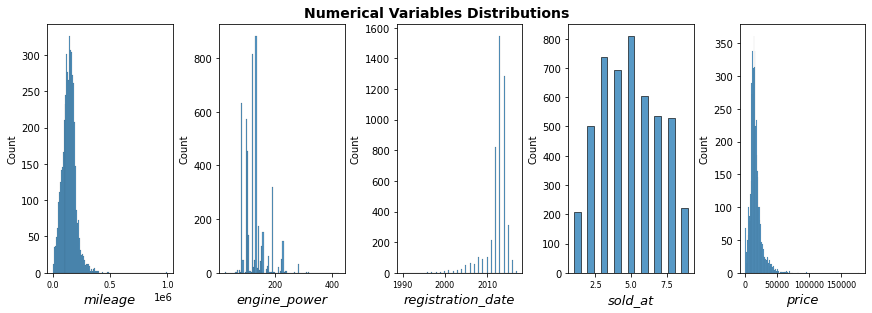

In [10]:
# Inspect num_var distributions
fig = plt.figure(figsize=[12,4],constrained_layout=True)
fig.suptitle('Numerical Variables Distributions', size=14, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig)
ax = [fig.add_subplot(spec[0, i]) for i in range(5)]
label_prop = {'size':13, 'style':'oblique'}

for i, var in enumerate([*num_var, *target]):
    sns.histplot(car_price_df[var], ax=ax[i])
    # Tweak using Matplotlib
    plt.sca(ax[i])
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=10)
    plt.xlabel(var, fontdict=label_prop)

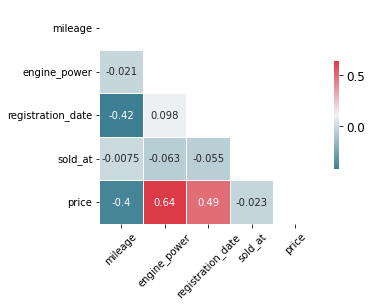

In [11]:
# Compute the correlation matrix on numeric variables
corr_num_var = car_price_df[[*num_var, *target]].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_num_var, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(
    corr_num_var,
    mask=mask,
    cmap=cmap,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    annot=True,
)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
# use matplotlib.colorbar.Colorbar object
cbar = g.collections[0].colorbar
# here set the labelsize
cbar.ax.tick_params(labelsize=12)

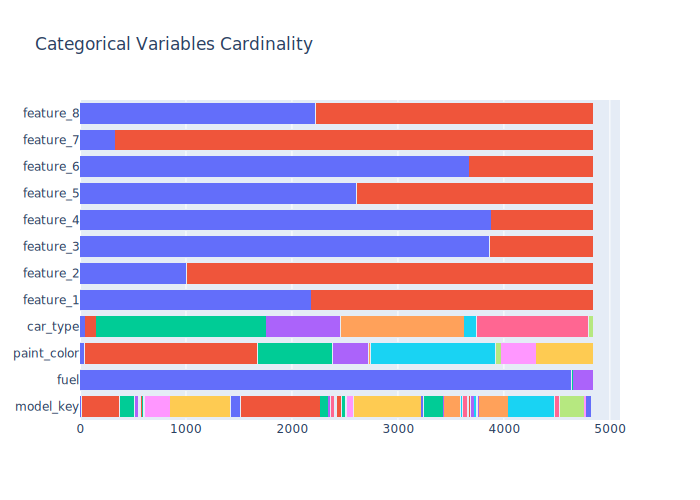

In [13]:
fig = go.Figure()
for col in cat_var:
    counted_df = car_price_df.groupby(col).size().to_frame(col).T
    bar_plot = px.bar(counted_df, orientation='h')
    for category in bar_plot.data:
        fig.add_trace(category)
fig.update_layout(showlegend=False, barmode='stack', title='Categorical Variables Cardinality')
fig.show(renderer="svg")

In [12]:
# Decisions to make on Categorical Variables
# count car colors
print(car_price_df.paint_color.value_counts())
# Merge minority colors
minority_colors = ['red','beige','green','orange'] # ['green','orange'] #
car_price_df.loc[:, "paint_color"] = np.where(
    car_price_df.paint_color.isin(minority_colors), 'other', car_price_df.paint_color
)

black     1632
grey      1175
blue       710
white      537
brown      341
silver     329
red         52
beige       41
green       18
orange       6
Name: paint_color, dtype: int64


In [13]:
# count fuel
print(car_price_df.fuel.value_counts())

# drop hybrids and electrics
car_price_df.drop(car_price_df[car_price_df.fuel.isin(['hybrid_petrol','electro'])].index, inplace=True)

diesel           4639
petrol            191
hybrid_petrol       8
electro             3
Name: fuel, dtype: int64


In [14]:
# count model keys
# print(car_price_df.model_key.value_counts())
print(len(car_price_df.model_key.unique()))

# group model keys by series
for i in range(1, 8):
    model_mask = (
        car_price_df.model_key.str.startswith(f"{i}") |
        car_price_df.model_key.str.startswith(f"M{i}") |
        car_price_df.model_key.str.startswith(f"Z{i}")
    )
    car_price_df.loc[model_mask, "model_key"] = f"{i}00 series"
    car_price_df.loc[car_price_df.model_key.str.startswith(f"X{i}"), "model_key"] = f"X{i} series"

print(car_price_df.model_key.value_counts())
print(len(car_price_df.model_key.unique()))

72
300 series    1807
500 series    1152
100 series     564
X3 series      438
X1 series      274
X5 series      249
400 series     111
200 series      54
700 series      54
X6 series       51
X4 series       46
600 series      30
Name: model_key, dtype: int64
12


In [15]:
# matrix of features
feature_df = car_price_df[cat_var + num_var]
y = car_price_df[target].values.reshape(-1)

n_cat = len(cat_var)
n_num = len(num_var)

numerical_columns_selector = make_column_selector(dtype_include="int64")
categorical_columns_selector = make_column_selector(dtype_exclude="int64")

numerical_columns = numerical_columns_selector(feature_df)
categorical_columns = categorical_columns_selector(feature_df)

In [16]:
dummy_regressor = DummyRegressor(strategy="median")

# save pipeline diagram in html file
with open('/workspaces/data_challenge/presentation/imgs/dummy_regressor.html', 'w') as f:
    f.write(estimator_html_repr(dummy_regressor))

cv_sfold = KFold(n_splits=5, shuffle=True, random_state=42)

dummy_result = cross_validate(
    dummy_regressor,
    feature_df,
    y,
    cv=cv_sfold,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
    ],
)

In [17]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

ridge_preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)
])

In [18]:
lin_ridge_model = Pipeline([
    ("preprocessor", ridge_preprocessor),
    ("ridge_reg", Ridge()),
])

# save pipeline diagram in html file
with open('/workspaces/data_challenge/presentation/imgs/ridge_regressor.html', 'w') as f:
    f.write(estimator_html_repr(lin_ridge_model))

lin_ridge_result = cross_validate(
    lin_ridge_model,
    feature_df,
    y,
    cv=cv_sfold,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
    ],
)

In [19]:
set_unknown_value = np.nan

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=set_unknown_value),
        categorical_columns_selector,
    ),
    remainder="passthrough",
)

In [20]:
rand_forest = Pipeline([
    ("preprocessor", ordinal_encoder),
    ("regressor", RandomForestRegressor(
        n_jobs=2,
        # random_state=42,
    )),
])

# save pipeline diagram in html file
with open('/workspaces/data_challenge/presentation/imgs/rnd_for_regressor.html', 'w') as f:
    f.write(estimator_html_repr(rand_forest))

rnd_for_result = cross_validate(
    rand_forest,
    feature_df,
    y,
    cv=cv_sfold,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
    ],
    return_train_score=True,
    return_estimator=True,
)

In [21]:
grad_boost = Pipeline([
    ("preprocessor", ordinal_encoder),
    ("regressor", GradientBoostingRegressor()), # random_state=42)),
])

grad_boost_result = cross_validate(
    grad_boost,
    feature_df,
    y,
    cv=cv_sfold,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
    ],
)

In [22]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = [True] * n_cat + [False] * n_num

hist_native = Pipeline([
    ("preprocessor", ordinal_encoder),
    ("regressor", HistGradientBoostingRegressor(
        # random_state=42,
        categorical_features=categorical_mask,
    )),
])

hist_native_result = cross_validate(
    hist_native,
    feature_df,
    y,
    cv=cv_sfold,
    scoring="neg_mean_absolute_percentage_error",
)

Text(0, 0.5, 'R2 score')

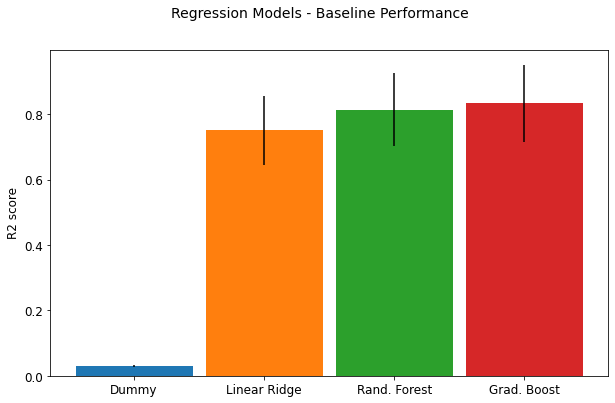

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x, width = np.arange(4), 0.9

items = [
    dummy_result["test_r2"],
    lin_ridge_result["test_r2"],
    rnd_for_result["test_r2"],
    grad_boost_result["test_r2"],
    # hist_native_result["test_score"],
]

cv_mean = [np.mean(np.abs(item)) for item in items]
cv_std = [np.std(item) for item in items]

ax.bar(
    x=x,
    height=cv_mean,
    width=width,
    yerr=cv_std,
    color=["C0", "C1", "C2", "C3"],
)
ax.set(
    # xlabel="Model",
    # ylabel="Mean Absolute Error [%]",
    # title="Mean Absolute Error [%]",
    xticks=x,
    xticklabels=["Dummy", "Linear Ridge", "Rand. Forest", "Grad. Boost"],
)
fig.suptitle("Regression Models - Baseline Performance", size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("R2 score", fontsize=12)

Text(0, 0.5, 'Mean Absolute Error [%]')

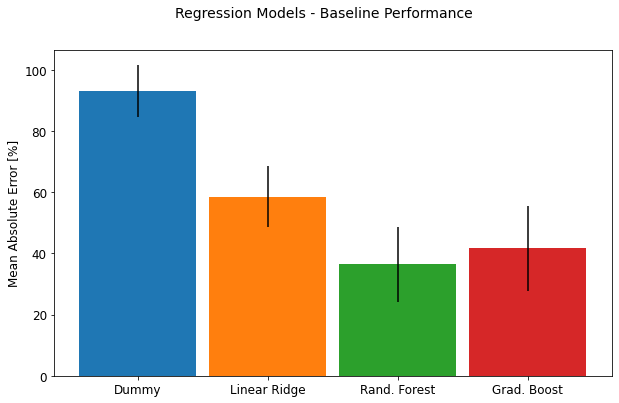

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x, width = np.arange(4), 0.9

items = [
    dummy_result["test_neg_mean_absolute_percentage_error"],
    lin_ridge_result["test_neg_mean_absolute_percentage_error"],
    rnd_for_result["test_neg_mean_absolute_percentage_error"],
    grad_boost_result["test_neg_mean_absolute_percentage_error"],
    # hist_native_result["test_score"],
]

cv_mean = [np.mean(np.abs(item))*100 for item in items]
cv_std = [np.std(item)*100 for item in items]

ax.bar(
    x=x,
    height=cv_mean,
    width=width,
    yerr=cv_std,
    color=["C0", "C1", "C2", "C3"],
)
ax.set(
    # xlabel="Model",
    # ylabel="Mean Absolute Error [%]",
    # title="Mean Absolute Error [%]",
    xticks=x,
    xticklabels=["Dummy", "Linear Ridge", "Rand. Forest", "Grad. Boost"],
)
fig.suptitle("Regression Models - Baseline Performance", size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("Mean Absolute Error [%]", fontsize=12)

In [25]:
lin_ridge_alphas = np.logspace(-2, 1, num=30)

# Declare the inner and outer cross-validation strategies
# inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = cv_sfold
outer_cv = cv_sfold

lin_ridge_cv = Pipeline([
    ("preprocessor", ridge_preprocessor),
    ("ridge_cv", RidgeCV(
        alphas=lin_ridge_alphas,
        # store_cv_values=True,
        cv=inner_cv,
        scoring="neg_mean_absolute_error",
    )),
])

In [26]:
cv_results_lin_ridge = cross_validate(
    lin_ridge_cv,
    feature_df,
    y,
    cv=outer_cv,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_error",
        "neg_median_absolute_error",
    ],
    return_train_score=True,
    return_estimator=True,
    n_jobs=2
)

In [27]:
param_distributions_rand_forest = {
    "regressor__n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "regressor__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
}

rand_forest_search_cv = RandomizedSearchCV(
    rand_forest,
    param_distributions=param_distributions_rand_forest,
    scoring="neg_mean_absolute_error",
    n_iter=40,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
    # random_state=42,
)

In [28]:
cv_results_rand_forest = cross_validate(
    rand_forest_search_cv,
    feature_df,
    y,
    cv=outer_cv,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_absolute_percentage_error",
    ],
    return_train_score=True,
    return_estimator=True,
    n_jobs=2
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [29]:
param_distributions_grad_boost = {
    "regressor__n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "regressor__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "regressor__learning_rate": loguniform(0.01, 1),
}

grad_boost_search_cv = RandomizedSearchCV(
    grad_boost,
    param_distributions=param_distributions_grad_boost,
    scoring="neg_mean_absolute_error",
    n_iter=80,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
    # random_state=42,
)

In [30]:
cv_results_grad_boost = cross_validate(
    grad_boost_search_cv,
    feature_df,
    y,
    cv=outer_cv,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_absolute_percentage_error",
    ],
    return_train_score=True,
    return_estimator=True,
    n_jobs=2
)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


Text(0, 0.5, 'Mean Absolute Error [%]')

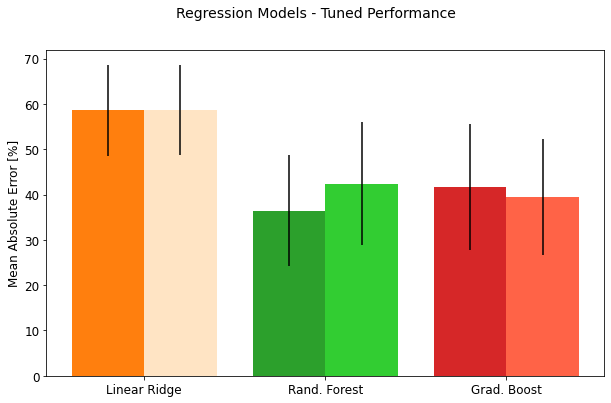

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x, width = np.arange(3), 0.4

items = [
    (lin_ridge_result["test_neg_mean_absolute_percentage_error"], cv_results_lin_ridge["test_neg_mean_absolute_percentage_error"]),
    (rnd_for_result["test_neg_mean_absolute_percentage_error"], cv_results_rand_forest["test_neg_mean_absolute_percentage_error"]),
    (grad_boost_result["test_neg_mean_absolute_percentage_error"], cv_results_grad_boost["test_neg_mean_absolute_percentage_error"]),
    # hist_native_result["test_score"],
]

cv_mean = [[np.mean(np.abs(item1))*100, np.mean(np.abs(item2))*100] for item1, item2 in items]
cv_std = [[np.std(item1)*100, np.std(item2)*100] for item1, item2 in items]

ax.bar(
    x=x - width/2,
    height=[a_mean[0] for a_mean in cv_mean],
    width=width,
    yerr=[a_std[0] for a_std in cv_std],
    color=["C1", "C2", "C3"],
    label="Default"
)
ax.bar(
    x=x + width/2,
    height=[a_mean[1] for a_mean in cv_mean],
    width=width,
    yerr=[a_std[1] for a_std in cv_std],
    color=["bisque", "limegreen", "tomato"],
    label="Tuned"
)
ax.set(
    # xlabel="Model",
    # ylabel="Mean Absolute Error [%]",
    # title="Mean Absolute Error [%]",
    xticks=x,
    xticklabels=["Linear Ridge", "Rand. Forest", "Grad. Boost"],
)
fig.suptitle("Regression Models - Tuned Performance", size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("Mean Absolute Error [%]", fontsize=12)

In [32]:
# Split data using Cross Validator
# _ = cv_sfold.get_n_splits(feature_df)
data_to_train = []
target_to_train = []
data_to_test = []
target_to_test = []
for train_index, test_index in cv_sfold.split(feature_df):
    data_to_train.append(feature_df.iloc[train_index, :])
    data_to_test.append(feature_df.iloc[test_index, :])
    target_to_train.append(y[train_index])
    target_to_test.append(y[test_index])

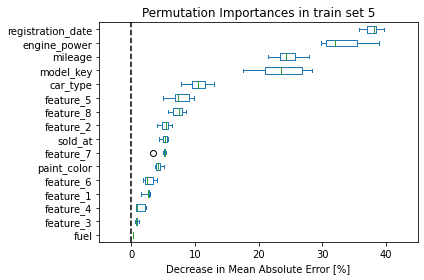

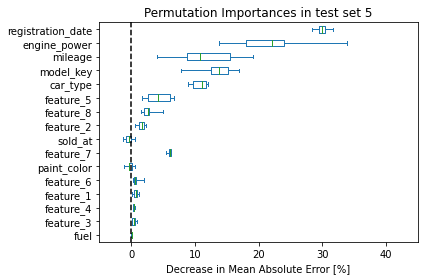

In [33]:
for iFold in range(4,5):

    train_pi = permutation_importance(
        rnd_for_result['estimator'][iFold],
        data_to_train[iFold],
        target_to_train[iFold],
        n_repeats=10,
        random_state=42,
        n_jobs=2,
        scoring=[
            "r2",
            "neg_mean_absolute_percentage_error",
        ]
    )

    test_pi = permutation_importance(
        rnd_for_result['estimator'][iFold],
        data_to_test[iFold],
        target_to_test[iFold],
        n_repeats=10,
        random_state=42,
        n_jobs=2,
        scoring=[
            "r2",
            "neg_mean_absolute_percentage_error",
        ]
    )
    sorted_importances_idx = train_pi["neg_mean_absolute_percentage_error"].importances_mean.argsort()
    train_importances = pd.DataFrame(
        train_pi["neg_mean_absolute_percentage_error"].importances[sorted_importances_idx].T*100,
        columns=feature_df.columns[sorted_importances_idx],
    )
    test_importances = pd.DataFrame(
        test_pi["neg_mean_absolute_percentage_error"].importances[sorted_importances_idx].T*100,
        columns=feature_df.columns[sorted_importances_idx],
    )

    for name, importances in zip(["train", "test"], [train_importances, test_importances]):
        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances in {name} set {iFold+1}")
        ax.set_xlabel("Decrease in Mean Absolute Error [%]")
        plt.xlim([-5, 45])
        ax.axvline(x=0, color="k", linestyle="--")
        ax.figure.tight_layout()

In [34]:
# refit model with less features
red_feature_df = car_price_df[[
    'model_key',
    'car_type',
    'feature_2',
    'feature_5',
    'feature_7',
    'feature_8'
] + num_var]

red_cat_cols = categorical_columns_selector(red_feature_df)

In [35]:
red_rnd_for_result = cross_validate(
    rand_forest,
    red_feature_df,
    y,
    cv=cv_sfold,
    scoring=[
        "r2",
        "neg_mean_absolute_percentage_error",
    ],
    return_train_score=True,
    return_estimator=True,
)

In [36]:
print(red_feature_df.shape)
print(red_rnd_for_result["test_neg_mean_absolute_percentage_error"])
# Compare against model containing all features
print(rnd_for_result["test_neg_mean_absolute_percentage_error"])

(4830, 10)
[-0.18602494 -0.30860056 -0.60053015 -0.37476161 -0.42846616]
[-0.18451835 -0.30045181 -0.55562036 -0.36756138 -0.4153516 ]
